In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm
from tqdm import tqdm
from functions import (
    SimulateRateManager,
    SolverRateManager,
    EigenvectorRateManager,
    get_eq_times,
)
from setup import setup_matplotlib, one_col, two_col, std_height

setup_matplotlib()

np.random.seed(42)

In [3]:
version = 2

k = 1
border = 0
x_0 = -1
N_x_border = 12.5  # 24.5
max_t = 10
ntau = 2
force = "cusp_force"
# absorbing = True


dx = (border - x_0) / N_x_border
sb = 40.5 * dx  #  80.5 * dx #with .5, 0 not included


f = 15
N_p = 2_000
N_loop = 10

eq_perc = 0.75
eq_f = 0.75
q_f = np.log(1 - eq_f) / np.log(1 - eq_perc)

ntau_sim = ntau * f


# x_s = np.arange(-sb, sb + 1e-6, dx)
# i_zero = np.argmin((x_s - x_0) ** 2)
# N_x = len(x_s)

s_s = np.arange(0.2, 0.81, 0.1)
# s_s = np.array([0.3])
# ltaus = np.array([0.1])
ltaus = np.concatenate(([0, 0.05], np.arange(0.2, np.pi / 2, 0.2)))

In [4]:
print(dx, sb)

0.08 3.24


In [5]:
def get_sim_rates(
    s_s, ltaus, N_p, N_loop, max_t, ntau_sim, x_0, force, border, q_f, absorbing
):
    sim_rate = np.empty((len(s_s), len(ltaus), 4), float)
    my_rate_manager = SimulateRateManager()

    for j, s in enumerate(tqdm(s_s)):
        D = s**2 / 2

        for i, ltau in enumerate(ltaus):
            ldt = ltau / ntau_sim if ltau > 0 else ltaus[1] / ntau_sim
            rel_time = q_f * get_eq_times(ltau, D, eq_perc, a=0, b=1)
            N_t = max(int(2 * rel_time / ldt), int(max_t / ldt), 30)

            sim_ts = (
                np.arange(-ntau_sim, N_t) * ldt if ltau > 0 else np.arange(0, N_t) * ldt
            )

            res = my_rate_manager.run(
                N_p=N_p,
                N_loop=N_loop,
                N_t=N_t,
                ntau=ntau_sim if ltau > 0 else 0,
                s=s,
                dt=ldt,
                x_0=x_0,
                force=force,
                border=border,
                absorbing=absorbing,
            )
            if absorbing:
                sim_sur = res["sim_sur"]
            else:
                sim_sur = 2 * res["sim_sur"] - 1

            sim_cond = (sim_ts > rel_time) * (sim_sur > 0.05)
            sim_rates = [
                -np.mean(np.diff(np.log(sim_sur[i, this_sim_cond])) / ldt)
                for i, this_sim_cond in enumerate(sim_cond)
            ]

            mean_sim_rates = np.mean(sim_rates, axis=0)
            sim_rate[j, i] = (
                np.mean(sim_rates),
                np.std(sim_rates) / np.sqrt(N_loop),
                np.min(mean_sim_rates),
                np.max(mean_sim_rates),
            )
    return sim_rate


def get_num_rate(
    s_s, ltaus, max_t, N_x, sbs, ntau, x_0, force, border, q_f, absorbing, version
):
    num_rate = np.empty((len(s_s), len(ltaus), 4), float)
    my_solver_rate_manager = SolverRateManager()

    for j, s in enumerate(tqdm(s_s)):
        D = s**2 / 2

        for i, ltau in enumerate(ltaus):
            ldt = ltau / ntau if ltau > 0 else ltaus[1] / ntau
            rel_time = q_f * get_eq_times(ltau, D, eq_perc, a=0, b=1)
            N_t = max(int(2 * rel_time / ldt), int(max_t / ldt), 30)

            ts = np.arange(0, N_t) * ldt

            res = my_solver_rate_manager.run(
                N_t=N_t,
                N_x=N_x,
                sbs=sbs,
                ntau=ntau if ltau > 0 else 0,
                s=s,
                dt=ldt,
                x_0=x_0,
                force=force,
                border=border,
                absorbing=absorbing,
                version=version,
            )
            if absorbing:
                num_sur = res["num_sur"]
            else:
                num_sur = 2 * res["num_sur"] - 1

            num_cond = (ts > rel_time) * (num_sur > 0.05)
            num_rates = -np.mean(np.diff(np.log(num_sur[num_cond])) / ldt)
            num_rate[j, i] = (
                np.mean(num_rates),
                0,
                np.min(num_rates),
                np.max(num_rates),
            )
    return num_rate


def get_num_rate_st(
    s_s, ltaus, max_t, N_x, sbs, ntau, x_0, force, border, q_f, absorbing, version
):
    num_rate = np.empty((len(s_s), len(ltaus), 4), float)
    my_solver_rate_manager = SolverRateManager()

    for j, s in enumerate(tqdm(s_s)):
        for i, ltau in enumerate(ltaus):
            ldt = ltau / ntau if ltau > 0 else ltaus[1] / ntau

            ldt_a = ldt * (1 + ltau)
            max_t_a = (1 + ltau) * max_t
            s_a = s * (1 + ltau)
            D_a = s_a**2 / 2

            rel_time = q_f * get_eq_times(0, D_a, eq_perc, a=0, b=1)
            N_t = max(
                int(2 * rel_time / ldt_a), int(max_t_a / ldt_a), int(30 * (1 + ltau))
            )

            ts = np.arange(0, N_t) * ldt_a

            res = my_solver_rate_manager.run(
                N_t=N_t,
                N_x=N_x,
                sbs=sbs,
                ntau=0,
                s=s_a,
                dt=ldt_a,
                x_0=x_0,
                force=force,
                border=border,
                absorbing=absorbing,
                version=version,
            )
            if absorbing:
                num_sur = res["num_sur"]
            else:
                num_sur = 2 * res["num_sur"] - 1

            num_cond = (ts > rel_time) * (num_sur > 0.05)
            num_rates = (
                -np.mean(np.diff(np.log(num_sur[num_cond])) / ldt_a) * 1 / (1 + ltau)
            )
            num_rate[j, i] = (
                np.mean(num_rates),
                0,
                np.min(num_rates),
                np.max(num_rates),
            )
    return num_rate


def get_eig_rate(s_s, ltaus, N_x, sbs, ntau, force, version):
    eig_rate = np.zeros((len(s_s), len(ltaus)), float)
    my_eigen_rate_manager = EigenvectorRateManager()

    for j, s in enumerate(tqdm(s_s)):
        for i, ltau in enumerate(ltaus):
            ldt = ltau / ntau if ltau > 0 else ltaus[1] / ntau
            #  N_x, sb, ntau, s, dt, force, version
            res = my_eigen_rate_manager.run(
                N_x=N_x,
                sbs=sbs,
                ntau=ntau if ltau > 0 else 0,
                s=s,
                dt=ldt,
                force=force,
                version=version,
            )

            eig_rate[j, i] = res["eig_rate"]
    return eig_rate

In [6]:
both_sim_rate = []
both_num_rate = []
both_num_rate_st = []
for absorbing in [False, True]:
    if absorbing:
        N_x = int((border + sb) / dx)
        sbs = [-sb, border - dx / 2]
    else:
        N_x = int((2 * sb) / dx) + 1
        sbs = [-sb, sb]

    both_sim_rate.append(
        get_sim_rates(
            s_s, ltaus, N_p, N_loop, max_t, ntau_sim, x_0, force, border, q_f, absorbing
        )
    )
    both_num_rate.append(
        get_num_rate(
            s_s,
            ltaus,
            max_t,
            N_x,
            sbs,
            ntau,
            x_0,
            force,
            border,
            q_f,
            absorbing,
            version,
        )
    )
    both_num_rate_st.append(
        get_num_rate_st(
            s_s,
            ltaus,
            max_t,
            N_x,
            sbs,
            ntau,
            x_0,
            force,
            border,
            q_f,
            absorbing,
            version,
        )
    )
    if absorbing:
        eig_rate = get_eig_rate(s_s, ltaus, N_x, sbs, ntau, force, version)

  0%|          | 0/7 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 28.19it/s]/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_60831/664530185.py:168: ComplexWarning: Casting complex values to real discards the imaginary part
  eig_rate[j, i] = res["eig_rate"]
100%|██████████| 7/7 [00:00<00:00, 200.46it/s]


In [7]:
# Kramers
k_t = np.cos(ltaus) / (1 + np.sin(ltaus))  # new stiffness
D_t = (s_s**2) / 2
kramers = (
    1 / (2 * np.pi) * k_t[None, :] * np.exp(-k_t[None, :] * 1**2 / (2 * D_t[:, None]))
)
new_kramers = (
    1
    / (np.sqrt(2 * np.pi * D_t[:, None]))
    * k_t[None, :] ** (3 / 2)
    * 1
    * np.exp(-k_t[None, :] * 1**2 / (2 * D_t[:, None]))
)

# Visualtisation

In [96]:
absorbing = True

if absorbing:
    sim_rate = both_sim_rate[1]
    num_rate = both_num_rate[1]
    num_rate_st = both_num_rate_st[1]
else:
    sim_rate = both_sim_rate[0]
    num_rate = both_num_rate[0]
    num_rate_st = both_num_rate_st[0]

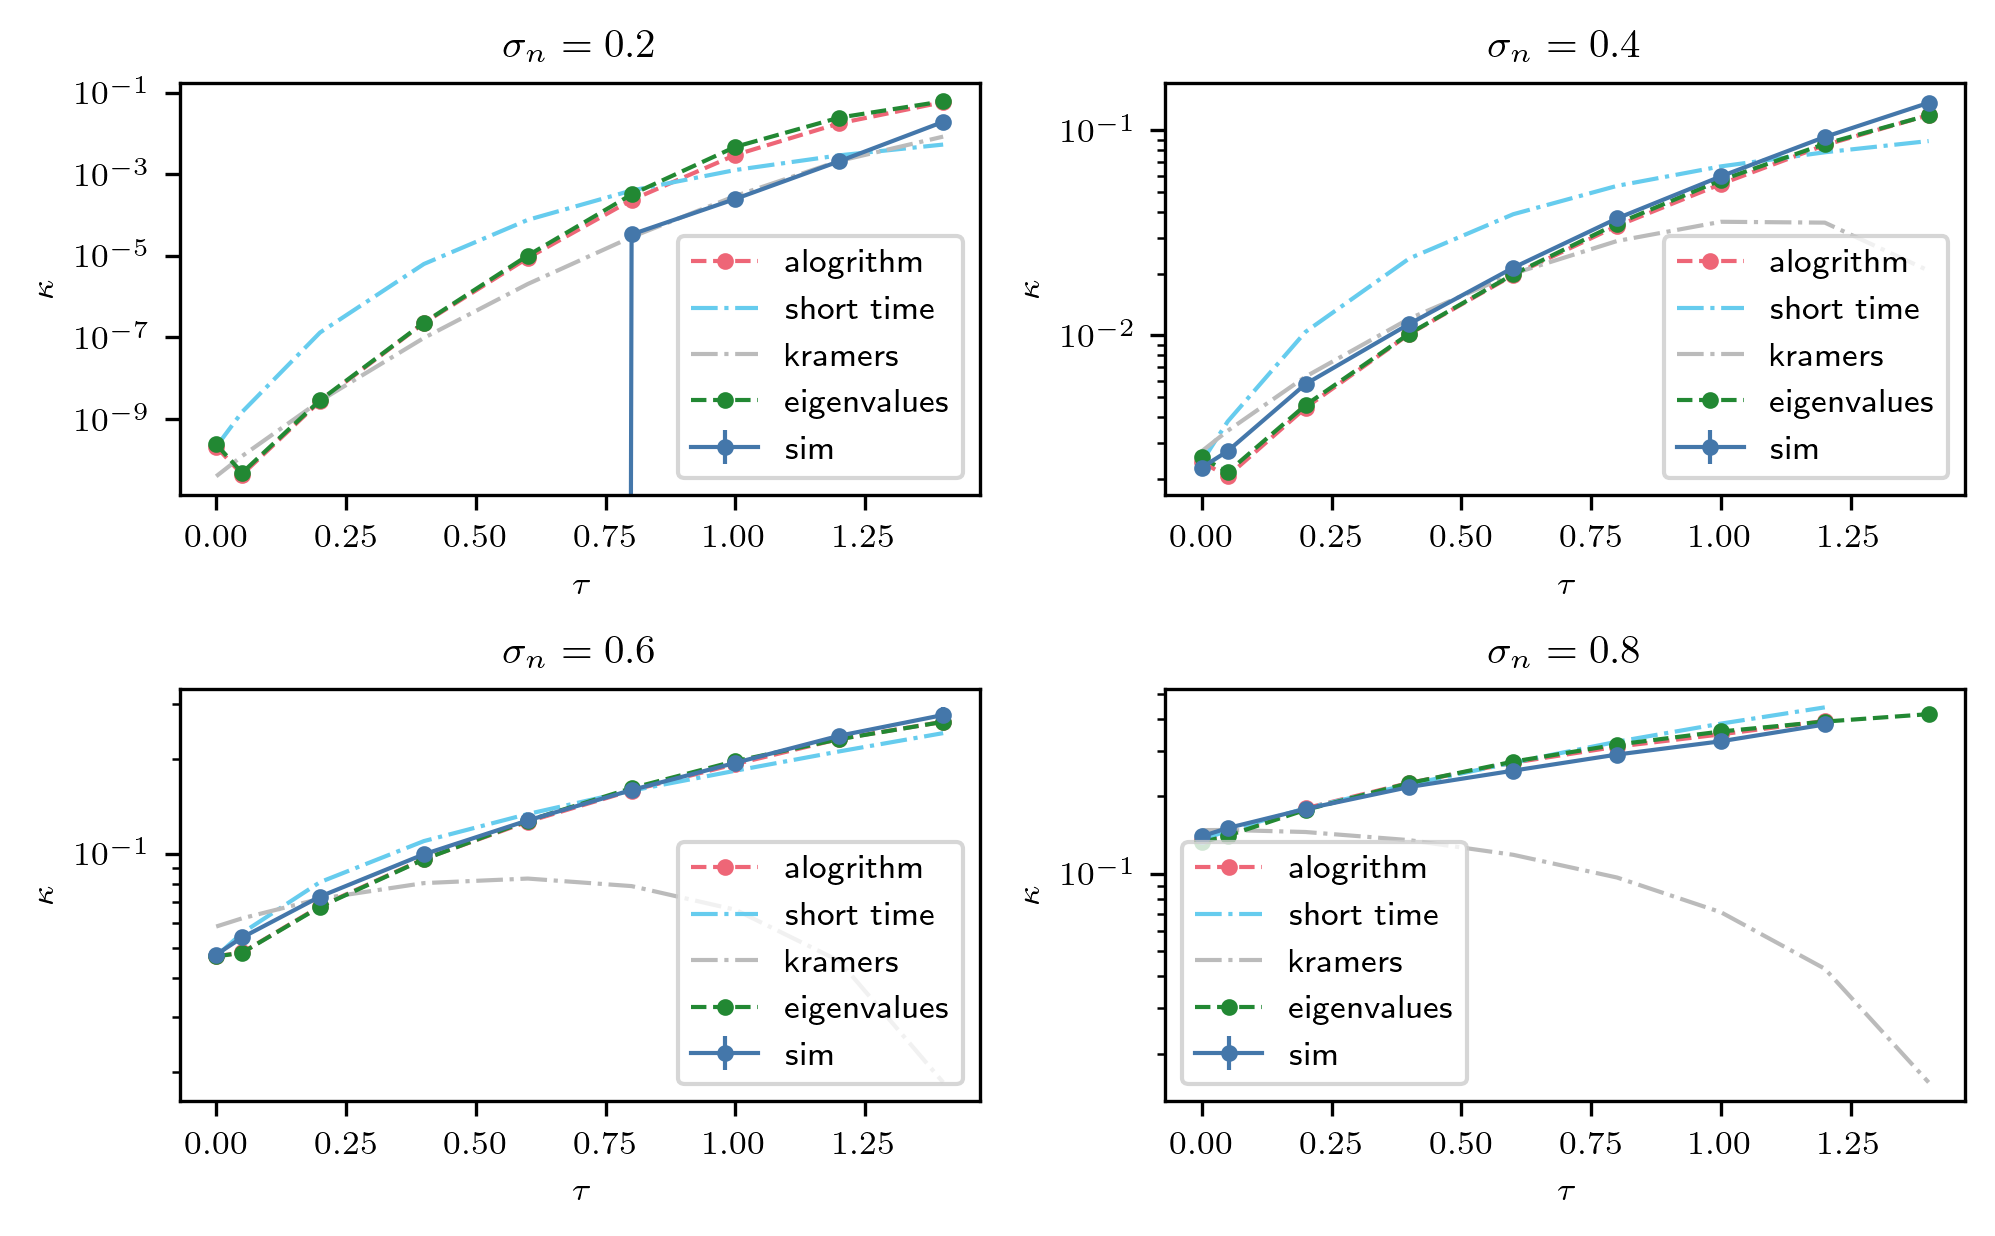

In [99]:
fig, axs = plt.subplots(2, 2, figsize=(two_col, 2 * std_height))
for j, ax in enumerate(axs.flatten()):
    i = 2 * j
    ax.set_title(f"$\sigma_n = {round(s_s[i], 2)}$")
    ax.errorbar(
        ltaus,
        sim_rate[i, :, 0],
        sim_rate[i, :, 1],
        marker=".",
        color=f"C0",
        label="sim",
    )
    ax.plot(
        ltaus, num_rate[i, :, 0], marker=".", ls="--", color=f"C1", label="alogrithm"
    )
    ax.plot(ltaus, num_rate_st[i, :, 0], ls="-.", color=f"C4", label="short time")
    ax.plot(ltaus, new_kramers[i, :], ls="-.", color=f"C6", label="kramers")
    # if absorbing:
    #     ax.plot(ltaus, eig_rate[i, :], marker = '.', ls="--", color=f"C2", label = "eigenvalues")

    ax.set_yscale("log")
    # ax.set_ylim(0.7*ax.set_ylim()[0], ax.set_ylim()[1])
    # y = ax.set_ylim()[0]*1.2 if i > 0 else ax.set_ylim()[0]*2.2
    # ax.vlines([1 / np.e / k], *plt.ylim(), color="black")
    # ax.text(0.5 * 1 / np.e / k, y, "Regim I", ha="center", va="center")
    # ax.text(0.5 * (1 / np.e / k + np.pi / 2 / k), y, "Regim II", ha="center", va="center")

    ax.legend()
    ax.set_xlabel(r"$\tau$")
    ax.set_ylabel(r"$\kappa$")

plt.tight_layout()
label = "absorbing" if absorbing else "full"
# plt.savefig(f"graphics/cusp_rate_{version}_{label}.pdf")

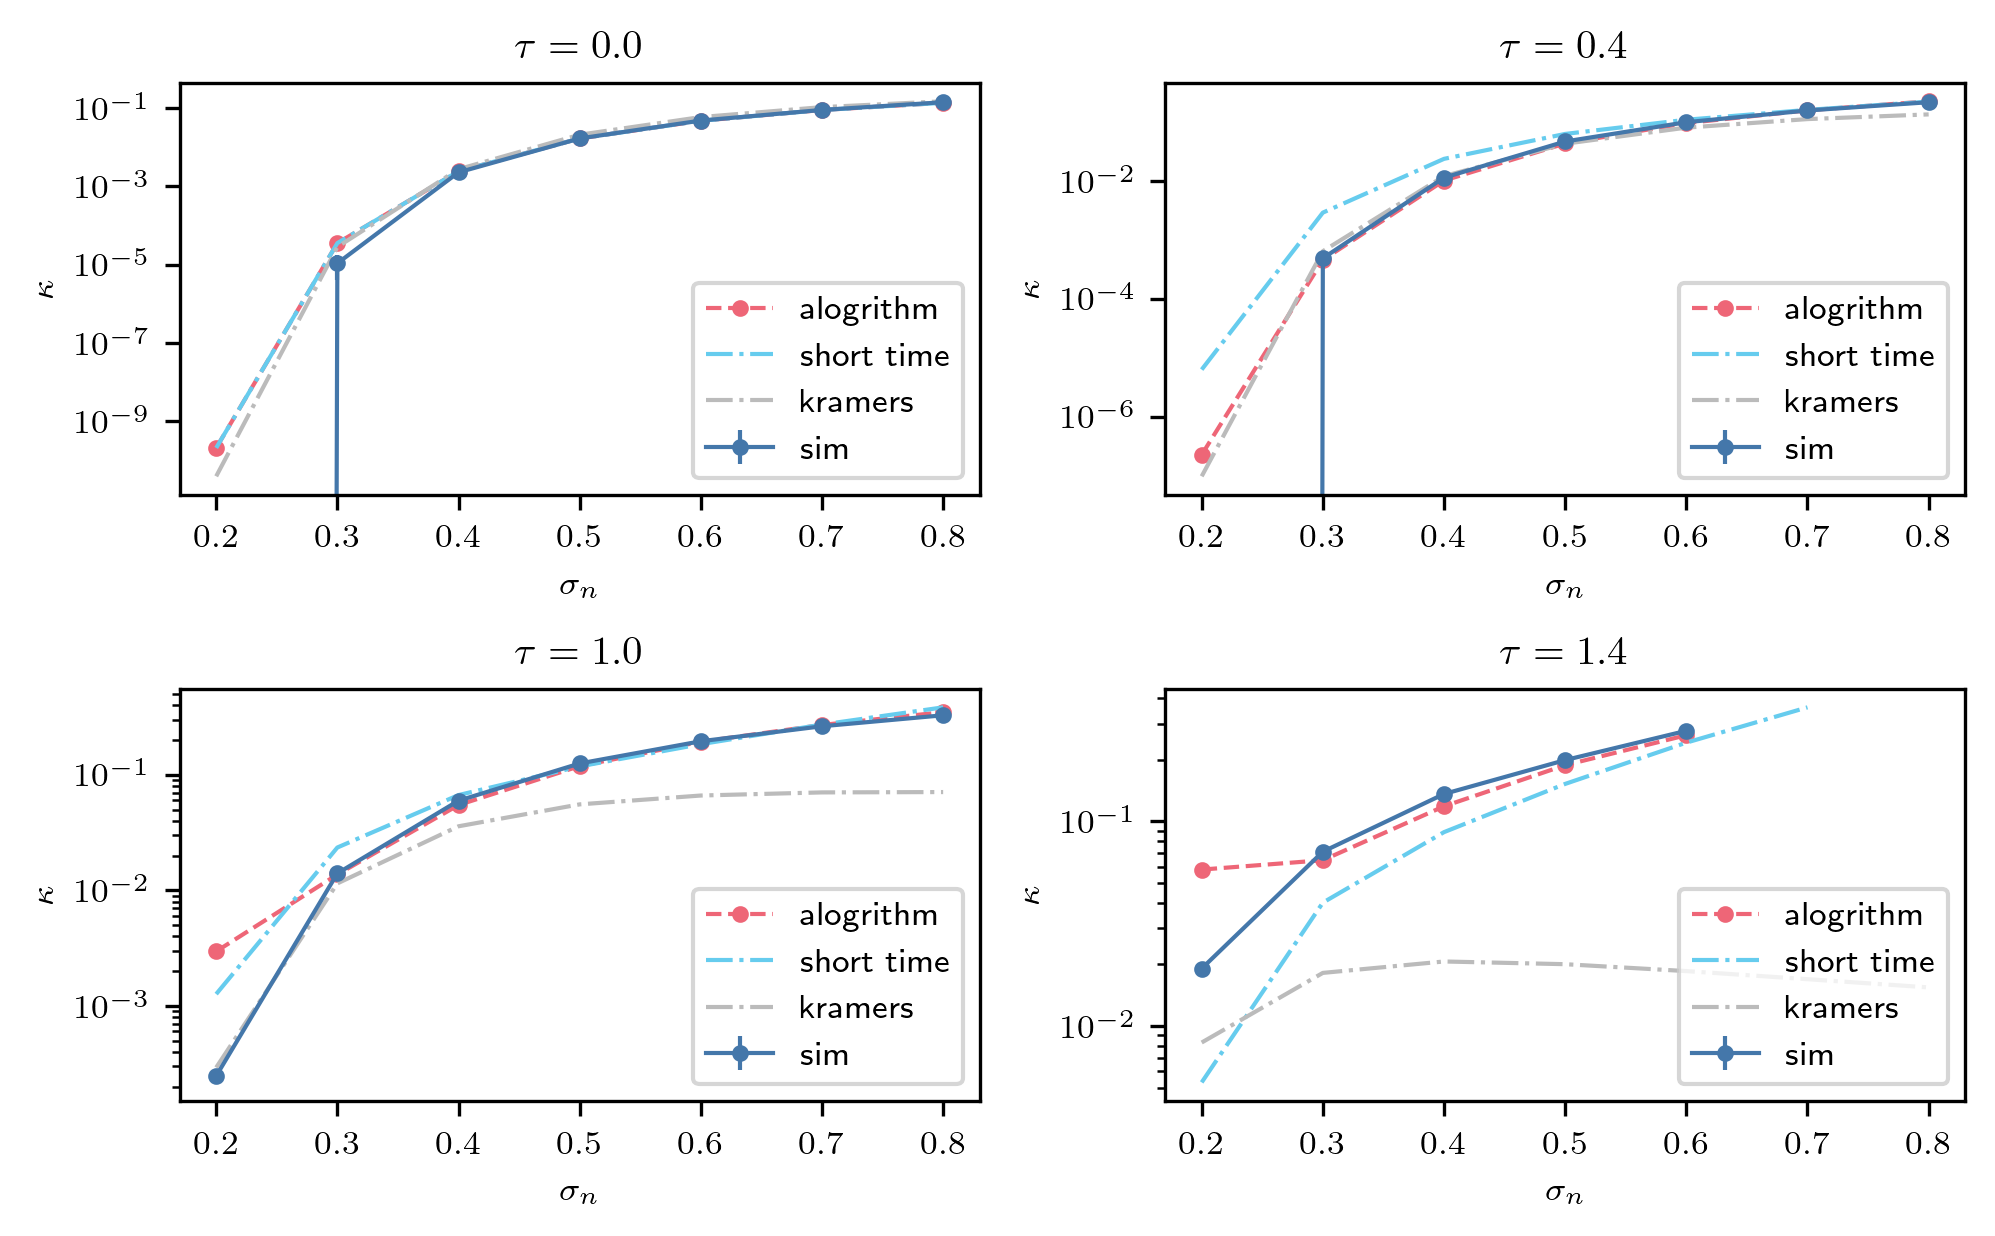

In [98]:
fig, axs = plt.subplots(2, 2, figsize=(two_col, 2 * std_height))
for j, ax in enumerate(axs.flatten()):
    i = [0, 3, 6, 8][j]
    ax.set_title(f"$\\tau = {round(ltaus[i], 2)}$")
    ax.errorbar(
        s_s,
        sim_rate[:, i, 0],
        sim_rate[:, i, 1],
        marker=".",
        color=f"C0",
        label="sim",
    )
    ax.plot(s_s, num_rate[:, i, 0], marker=".", ls="--", color=f"C1", label="alogrithm")
    ax.plot(s_s, num_rate_st[:, i, 0], ls="-.", color=f"C4", label="short time")
    ax.plot(s_s, new_kramers[:, i], ls="-.", color=f"C6", label="kramers")
    # if absorbing:
    #     ax.plot(ltaus, eig_rate[i, :], marker = '.', ls="--", color=f"C2")
    ax.legend()
    ax.set_xlabel(r"$\sigma_n$")
    ax.set_ylabel(r"$\kappa$")
    ax.set_yscale("log")
plt.tight_layout()

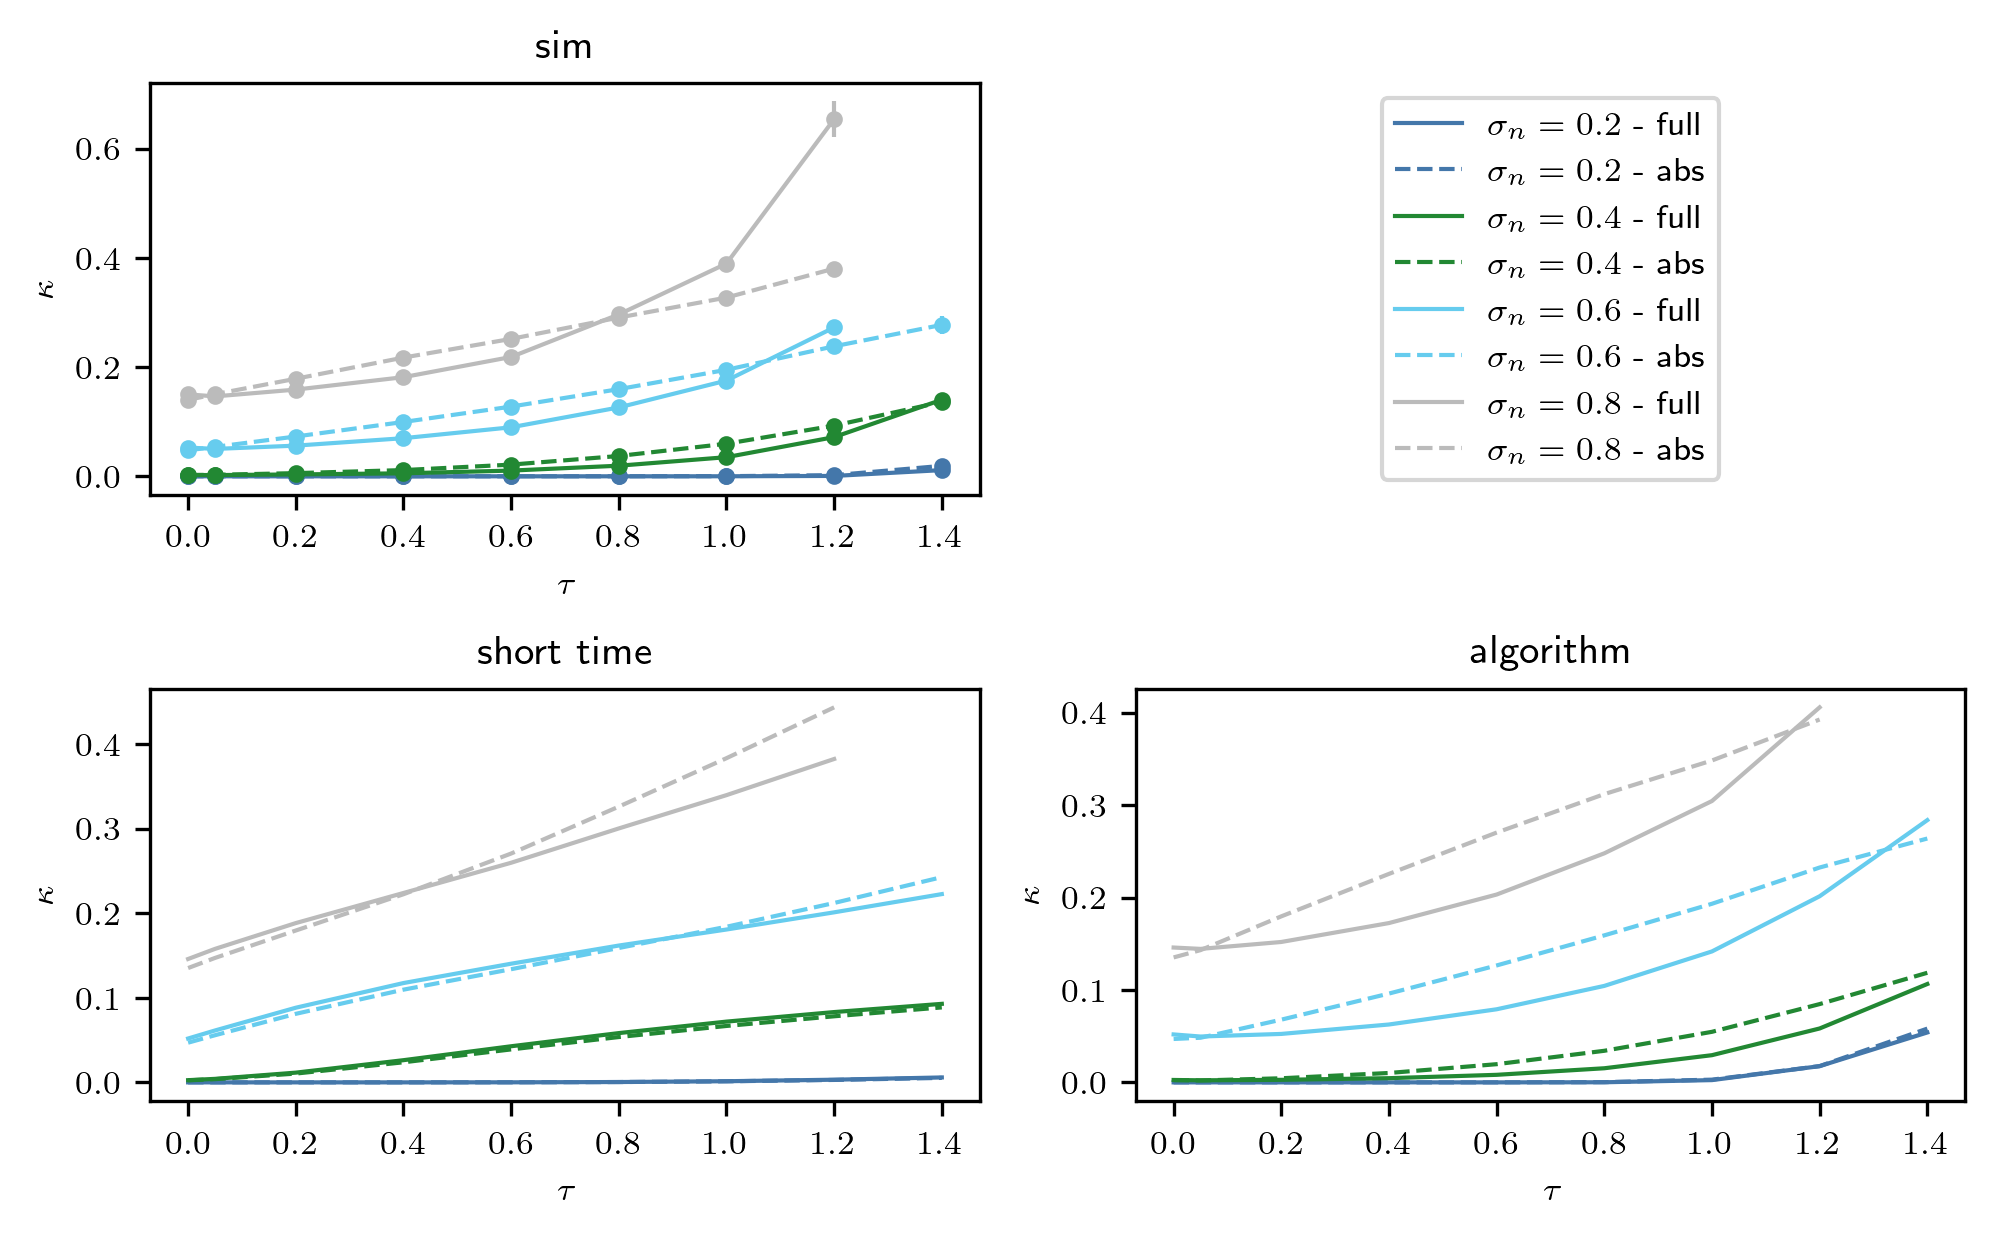

In [95]:
fig, axs = plt.subplots(2, 2, figsize=(two_col, 2 * std_height))
plot_obj = []
legends =[]
for i in range(0, len(s_s), 2):
    axs[0, 0].errorbar(
        ltaus,
        both_sim_rate[0][i, :, 0],
        both_sim_rate[0][i, :, 1],
        marker=".",
        color=f"C{i}",
        label=round(s_s[i], 2),
    )
    axs[0, 0].errorbar(
        ltaus,
        both_sim_rate[1][i, :, 0],
        both_sim_rate[1][i, :, 1],
        marker=".",
        ls="--",
        color=f"C{i}",
    )
    plot_obj.extend(
        axs[1, 1].plot(
            ltaus,
            both_num_rate[0][i, :, 0],
            ls="-",
            color=f"C{i}",
            label=round(s_s[i], 2),
        )
    )
    legends.append(f"$\sigma_n = {round(s_s[i], 2)}$ - full")
    plot_obj.extend(
        axs[1, 1].plot(ltaus, both_num_rate[1][i, :, 0], ls="--", color=f"C{i}")
    )
    legends.append(f"$\sigma_n = {round(s_s[i], 2)}$ - abs")

    axs[1, 0].plot(
        ltaus,
        both_num_rate_st[0][i, :, 0],
        ls="-",
        color=f"C{i}",
        label=round(s_s[i], 2),
    )
    axs[1, 0].plot(ltaus, both_num_rate_st[1][i, :, 0], ls="--", color=f"C{i}")

for ax in [axs[0,0], axs[1,0], axs[1,1]]:
    ax.set_xlabel(r'$\tau$')
    ax.set_ylabel(r'$\kappa$')

axs[0, 0].set_title("sim")
axs[1, 1].set_title("algorithm")
axs[1, 0].set_title("short time")

axs[0,1].legend(plot_obj, legends, loc = "center")
axs[0,1].set_axis_off()

plt.tight_layout()
plt.savefig(f"graphics/cusp_compare_rate_type_{version}.pdf")